In [ ]:
# this is a tool for debugging in python that you can use it for debugging in this assignment.
# when you finished debugging, please remember to delete the decorater @pysnooper.snoop on top of the functions.
!pip install pysnooper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### [The Paper Reading](https://www.pnas.org/content/101/suppl_1/5228).

    Griffiths, Thomas L., and Mark Steyvers. "Finding scientific topics." Proceedings of the National academy of Sciences 101.suppl 1 (2004): 5228-5235.

The notations in the aforementioned reference varies. Please be careful when you are reading.


### A Short essay
1. The probabilistic graphcial models and dependencies for LDA model. Please define notations before refering to.  
2. The Gibbs sampling update steps for the parameters of LDA. Deriving the update steps should be straightforward after writing the dependencies of the parameters in the graphical model.
3. The goal of Gibbs Sampling for the inference Latent Dirichlet Allocation?


**Optional**

If you would like to know more about the mathematical and technical details, please read **Section 5**, [Parameter estimation for text analysis](http://www.arbylon.net/publications/text-est.pdf).

Please note that all the comments and notations in this jupyter notebook follows this reference for your convenience.

> 1.   Describe the probabilistic graphical models and dependencies for LDA model. Please define notations before referring to.

Notations in code:

$W$: number of unique words in corpus

$D$: number of documents

$T$: number of Topics

$α$: a hyperparameter value set to define θ document-topic probability distribution

$β$: a hyperparameter value set to define ϕ topic-word probability distribution

$θ^d$: probability distribution of topics in document d

$θ^d_j$: the probability of topic j in document d

$ϕ_j$: probability distribution of words in topic j

$ϕ^i_j$: the probability of word i in topic j

$z_d,_i$: the topic of the word i in the document d

$w_d,_i$: the word i in the document d

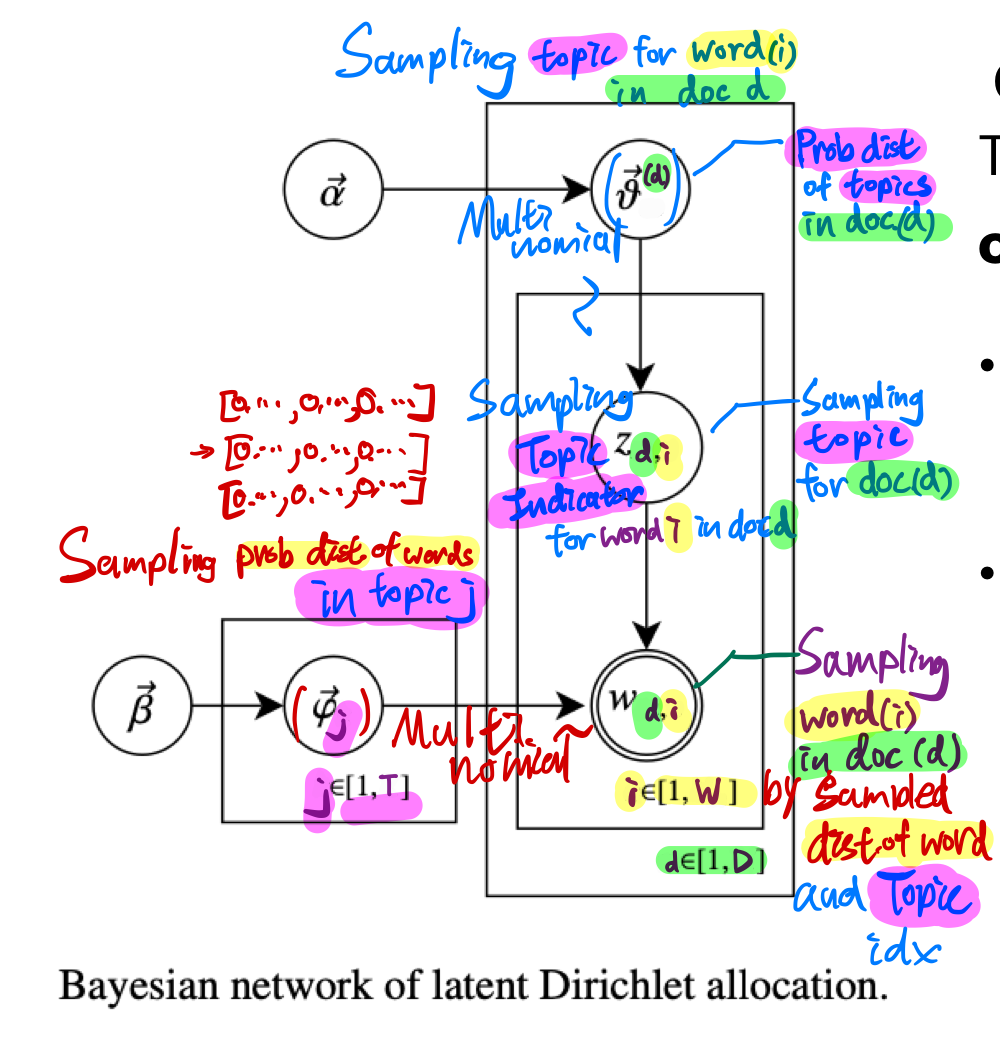

New documents will be generated by words flow, LDA aim to train and get the highest probability to mimic origin documents with new generated documents.

> 2.   Describe the Gibbs sampling update steps for the parameters of LDA. Deriving the update steps should be straight forward after writing the dependencies of the parameters in the graphical model.

Gibbs sampling is a special case of MCMC, which emulate high-dimensional probability distributions

P(z|w) = P(w, z) / ∫ P(w, z) dz

_____________________________

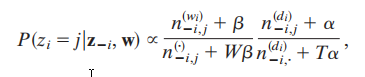

To count above numbers $n^w_j$ require matrix ($j*w$) , and $n^d_j$ require matrix ($d*j$)  

      step-1: randomly sample a topic to each word in each document, those same word can be assigned by different topic in a document.

      step-2: build matrix to store numbers

      topic-word matrix (T*W)
    T=5:
      [[3,5,3,6..5,3,2],
       [6,3,6,8..6,4,4],
       [4,2,4,5..3,2,4],
       [4,3,5,6..6,5,2],
       [6,8,6,2..7,6,6]]

      which stores the number of words in all documents by each topic

 topic_counts: $n^w_j$ = topic_word_matrix[:, w].sum(axis=1), count word frequency in topic j

      document-topic matrix (D*T)
    T=5:
      [[23,32,31,22,33],
       [86,68,66,88,66],
       ..
       [56,65,55,65,66]]

      which stores the number of words distributed for each topic in every document

  doc_counts: $n^d_j$ = doc_topic_matrix[d, :].sum(axis=1), count words of sampled topic j in document d




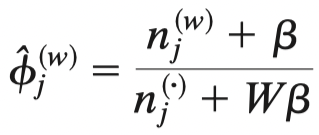,    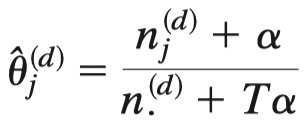

Gibbs:

  1.   Sampling topic j ($z_d,_i$) to selected $w_d,_i$ word i in document d from corpus,
  2.   Increment topic count $n^w_j$ in ($j∗w$)and document topic count $n^d_j$,
  3.   Update topic indicator $z_d,_i$ as sampled topic j.
  4.   Decrement hidden variable $z_d,_i$ in topic of both matrix, topic_counts, and document d in doc_counts as well
  5.   Plug in two updated matrix into $ϕ^w_j$ *(probability of word given assigned topic j)* and $θ^d_j$ *(probability of topic in document d)*
  6.   Update topic indicator $z_d,_i$ index by random multinomial sampling a topic for the selected $w_d,_i$ from corpus, from above norminalized ($P(w,z)/∑P(w,z)$) proportion of high-dimensional probability distributions (*full_conditional*)
  7.   To place back the word $w_d,_i$, Increment ***Updated*** hidden variable $z_d,_i$ in origin topic index of both matrix, topic_counts, and document d in doc_counts as well







>3.   Describe the goal of Gibbs Sampling for the inference Latent Dirichlet Allocation?

In each Gibbs sampling iteration, sampling a new topic assignment $z_{ij}$ for each word $w_{ij}$ in each document $i$. Based on the new topic assignments, update the topic distributions $\theta_i$ for each document and the topic-word distributions $\phi_k$ for each topic, and place back the word with new sampled topic. Repeating the iteration above of sampling new topic for word from multi-distribution and placing back, until all words of topics T in the corpus are updated.

In [ ]:
%matplotlib inline

## Part 2 Implementation of LDA and Inference via Gibbs sampling for LDA
Although latent Dirichlet allocation is still a relatively simple model, exact inference is generally intractable. The solution to this is to use approximate inference algorithms. Gibbs sampling is a special case of Markov-chain Monte Carlo (MCMC) simulation and often yields relatively simple algorithms for approximate inference in high-dimensional models such as LDA. Therefore we select this approach and present a derivation that is more detailed than the original one by Griffiths and Steyvers.


To derive a Gibbs sampler for LDA, we apply the hidden-variable method from above. The hidden variables in our model are $z_{d, w}$, i.e., the topic that appear with the word $w$ in document $d$ . We do not need to include, i.e., can integrate out, the parameter sets $\Theta$ and $\Phi$ because they can be interpreted as statistics of the associations between the observed word and the corresponding topic, the state variables of the Markov chain.

In this assignment, we will use Gibbs sampling for LDA.
distribution. During the inference, the distribution of topics in docuemnts, $\mathbf{\theta}$, the distribution of words in topics $\mathbf{\phi}$, and likelihood
$p(\mathbf{w}|\mathbf{z})$ are estimated.


### Settings
1. we have $T$ topics
2. The copus are consist of $D$ documents, and there are $W$ words within each document $d$.
3. For dirichlet distribution of $\mathbf{\phi}$, the the number of prior parameters are equal to the number of vocabulary. The prior parameters are all of the same value, $\beta$.
4. For dirichlet distribution of $\mathbf{\theta}$, the the number of prior parameters are equal to the number of topics. The prior parameters are all of the same value, $\alpha$.

###  Argument Definitions and Types



```
z: z must take in (d,w,i) as input, corresponding to
    topic indicator for i-th obserevation of word w in doc d.
    z is a python dictionary.
```
```
topic_word_matrix: of dimension (T, W).  
    It refers to the topic of each word. t-th row of topic_word_matrix corresponds to the word observation counts for topic $t$.

```     
In the first reference, ```topic_word_matrix[j, w]``` is noted as $n_j^{(w)}$, which is the number of times word $w$ has been assigned
to topic $j$.


```
doc_topic_matrix: of dimension (D, T). It refers to the topic counts for each document.

```
```doc_topic_matrix[d, j]``` is noted as $n_j^{(d)}$ the number of times a word from document $d$ has been assigned to topic $j$.  


```
topic_counts: the total number of words has been assigned to each topic.
```



```
doc_counts: document topic sum
```


log_likelihood corresponding to the $log(p(\mathbf{w}|\mathbf{z}))$. $p(\mathbf{w}|\mathbf{z})$ is equation [2] in the first reference.




In [ ]:
# -*- coding: utf-8 -*-
"""
LDA implementation in Python

@author: Michael Zhang
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy
import pysnooper

class LDA(object):
  def __init__(self, tdm, T, alpha = 1., beta=1., iteration=100):
    """
    tdm: the copus, of (D * Num_words_in_corpus),
        the value of each entry is the counts of corresponding words in this the corresponding document.
        e.g.
        tdm[d, w] = number of word w appears in document d.
    T: the number of topics

    """
    self.tdm = tdm
    self.D, self.W = self.tdm.shape
    self.alpha = alpha
    self.beta = beta
    self.T = T
    self.iteration = iteration

    # z must take in (d,w,i) as input, corresponding to
    # topic indicator for i-th obserevation of word w in doc d
    self.z = {}
    self.topic_word_matrix = np.zeros((self.T, self.W))
    self.doc_topic_matrix = np.zeros((self.D, self.T))
    self.topic_counts = np.zeros(self.T)
    self.doc_counts = np.zeros(self.D)
    self.log_likelihood = np.zeros(self.iteration)
    self._init_matrix()

  @pysnooper.snoop('/content/drive/MyDrive/STAT4609/ASM6/init.log')
  def _init_matrix(self):
    """
    for all words
    1. sample a topic randomly from T topics for each word
    2. increment topic word count, self.topic_word_matrix
    3. increment document topic count,  self.doc_topic_matrix
    4. update the topic indicator z.
    """#tdm[d, w] = number of word w appears in document d.
    for d in range(self.D):
      doc = scipy.sparse.coo_matrix(self.tdm[d])
      word_freq_topic = zip(doc.col, doc.data)
      for w, frequency in word_freq_topic:
        for i in range(frequency):
          ############ Finish the following initialization steps #############
          # 1. sample a topic randomly from T topics for each word
          topic = np.random.randint(self.T)     #self.T -> topic
          # 2. increment topic word count, self.topic_word_matrix
          self.topic_word_matrix[topic, w] += 1 #self.W -> w
          # 3. increment document topic count,  self.doc_topic_matrix
          self.doc_topic_matrix[d, topic] += 1  #self.D -> d
          # 4. update the topic indicator z.
          # topic indicator z for i-th obserevation of word w in doc d
          self.z[(d,w,i)] = topic #\\self.z = {d:,w:,i:}
          ###################################################################
    self.topic_counts = self.topic_word_matrix.sum(axis=1)
    self.doc_counts = self.doc_topic_matrix.sum(axis=1)

  @pysnooper.snoop('/content/drive/MyDrive/STAT4609/ASM6/fit.log')
  def fit(self):
    for it in range(self.iteration):
      # iterate over all the documents -> self.doc_topic_matrix[d, topic]
      for d in range(self.D):
        # iterate over all the words in d -> self.topic_word_matrix[topic, w]
        for w in self.tdm[d].indices:
          # iterate over number of times observed word w in doc d
          for i in range(self.tdm[d,w]):
              # we apply the hidden-varible method of Gibbs sampler, the hidden variable is z[(d,w,i)]
              self.doc_topic_matrix[d,self.z[(d,w,i)]] -= 1
              self.doc_counts[d] -= 1
              self.topic_word_matrix[self.z[(d,w,i)],w] -= 1
              self.topic_counts[self.z[(d,w,i)]] -= 1
              ######++++++++++++++++++++++++++++++++++++++########
              # estimation of phi and theta for the current corpus
              # according to equation [6] [7]
              #
              phi_hat = (self.topic_word_matrix[:, w] + self.beta)/(self.topic_counts + self.W * self.beta)     #[6] n_T^(·) = self.topic_word_matrix[∑sum(t:T),] + Wβ
              theta_hat = (self.doc_topic_matrix[d, :] + self.alpha)/(self.doc_counts[d] + self.T * self.alpha) #[7] n·^(d) + Tα

              # calculate the full conditional distribution, i.e. equation [5],
              # please observe the relationship between equation [5], [6], and [7]
              full_conditional = phi_hat*theta_hat # ∝
              # normalize full_conditional such that it summation equals to 1.
              full_conditional = full_conditional/ sum(full_conditional) # weight% = x/∑x ; ∑weight% = 1
              'print(full_conditional)                          #[0 0 1 0 0]'
              'print(np.random.multinomial(1,full_conditional)) #[0.07583669 0.21302469 0.25279103 0.23755237 0.22079521] sample multidist. of 5 topics'
              # sample a topic for i-th obserevation of word w in doc d based on full_conditional
              self.z[(d,w,i)] = np.random.multinomial(1,full_conditional).argmax()
              'print(self.z[(d,w,i)]) #sampled Topic index of [0.07583669 0.21302469 0.25279103 0.23755237 0.22079521]'
              # update z[(d,w,i)], doc_topic_matrix, doc_counts, topic_word_matrix, topic_counts here.
              self.doc_topic_matrix[d,self.z[(d,w,i)]] += 1
              self.doc_counts[d] += 1
              self.topic_word_matrix[self.z[(d,w,i)],w] += 1
              self.topic_counts[self.z[(d,w,i)]] += 1
              ############################################################


      # Equation 2  log P(w|z)  for each iteration based on Equation [2]
      'ln( [Γ(Wβ) / Γ(β)^W] ^T) + ∑[ ∑ln(Γ(n_j^w+β)) - ln( Γ(∑n_j·+ Wβ) ) ]' #scipy.special.gammaln
      ratio = self.T*(scipy.special.gammaln(self.W*self.beta) - self.W*scipy.special.gammaln(self.beta))
      wnz = scipy.special.gammaln(self.topic_word_matrix + self.beta).sum(axis=1) #∑ln(Γ(n_j^w+β))
      zz = scipy.special.gammaln(self.topic_counts + self.W*self.beta)       #ln( Γ(∑n_j·+ Wβ)
      self.log_likelihood[it] = ratio + sum( wnz - zz )
      ############################################################
      print('Iteration %i\t LL: %.2f' % (it,self.log_likelihood[it]))



#### Trial

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pysnooper
import pandas as pd

In [ ]:
T = 500/100
z = {}
D, W = sk_tdm.shape
for d in range(D):
  doc = scipy.sparse.coo_matrix(sk_tdm[d])
  word_freq_topic = zip(doc.col, doc.data)
  for w, frequency in word_freq_topic:       #tdm[d, w] = number of word w appears in document d.
                for i in range(frequency):
                  topic = np.random.randint(T)
                  z[(d,w,i)] = topic
df = pd.DataFrame(z, index=[0,1,2,100])
print(z)
df

### Experiment 1: Well separated synthetic dataset.

This synthetic dataset consists of 100 documents, and 500 words as total number of vocabulary There are 5 topics in total.

In this experiment, you are not required to write any additional code. Run the following code, and see if your topic_word_matrix could resemble true "phi", i.e. the true distribution of words in each topic, up to reordering.



In [ ]:
# dataloading
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
import scipy

synthetic_data = scipy.io.loadmat('/content/drive/MyDrive/STAT4609/ASM6/well_separated_synthetic.mat')
sk_tdm1 = scipy.sparse.csr_matrix(synthetic_data['W'])
sk_tdm1 # of shape 100 \times 500

<100x500 sparse matrix of type '<class 'numpy.int32'>'
	with 8552 stored elements in Compressed Sparse Row format>

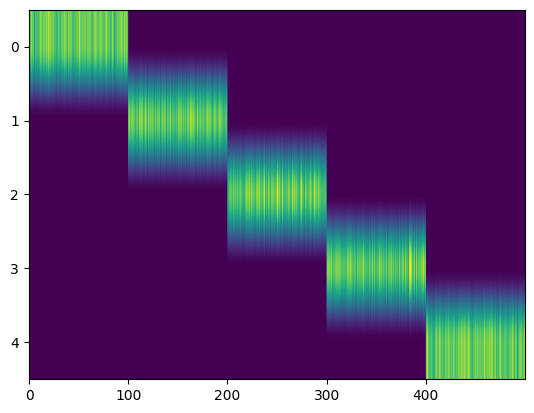

In [ ]:
import matplotlib.pyplot as plt
# first run LDA on synthetic data set,
# if code works then topic_word_matrix should
# resemble true "phi", up to reordering

# distribution of words in 5 topics,
plt.imshow(synthetic_data['phi'],aspect='auto')

In [ ]:
# run LDA with 5 topics on synthetic data set
lda = LDA(sk_tdm1, T=5, iteration=100)
lda.fit()


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/pysnooper/tracer.py", line 349, in __enter__
    sys.settrace(self.trace)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/pysnooper/tracer.py", line 355, in __exit__
    sys.settrace(stack.pop())



Iteration 0	 LL: -61598.22
Iteration 1	 LL: -60853.32
Iteration 2	 LL: -60664.40
Iteration 3	 LL: -60591.91
Iteration 4	 LL: -60442.14
Iteration 5	 LL: -60324.05
Iteration 6	 LL: -60405.03
Iteration 7	 LL: -60224.60
Iteration 8	 LL: -59967.91
Iteration 9	 LL: -59769.77
Iteration 10	 LL: -59819.07
Iteration 11	 LL: -59743.49
Iteration 12	 LL: -59626.69
Iteration 13	 LL: -59511.09
Iteration 14	 LL: -59370.28
Iteration 15	 LL: -59408.27
Iteration 16	 LL: -59332.86
Iteration 17	 LL: -59233.04
Iteration 18	 LL: -59203.30
Iteration 19	 LL: -59105.29
Iteration 20	 LL: -58997.97
Iteration 21	 LL: -59124.92
Iteration 22	 LL: -59013.84
Iteration 23	 LL: -59116.09
Iteration 24	 LL: -59154.90
Iteration 25	 LL: -59042.33
Iteration 26	 LL: -58999.43
Iteration 27	 LL: -58970.26
Iteration 28	 LL: -58964.81
Iteration 29	 LL: -58866.76
Iteration 30	 LL: -58835.89
Iteration 31	 LL: -58921.14
Iteration 32	 LL: -58773.32
Iteration 33	 LL: -58746.14
Iteration 34	 LL: -58641.84
Iteration 35	 LL: -58574.33
It

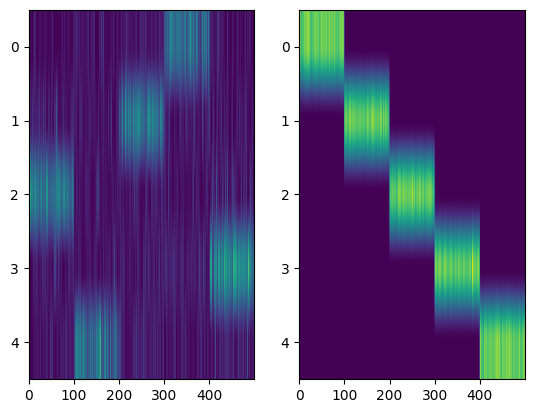

In [ ]:
# compare LDA topic word matrix and true topic word distribution
f,a = plt.subplots(1,2)

a[0].imshow(lda.topic_word_matrix, aspect='auto')
a[1].imshow(synthetic_data['phi'], aspect='auto')

### Experiment 2.

In this experiment, we use a real-world dataset, with 20 topics (newsgroups).
1. you need to build and fit LDA model.
2. get top 10 words in each topic, (should make sense)
3. plot train loglikelihood, i.e. equation [2] in the reference paper, (should increase over iterations)




In [ ]:
# data loading
# create term document matrix, documents from collection of 20 newsgroups
count_vector = CountVectorizer(stop_words="english",
                                min_df=.01,
                                max_df=.95)
data_set = datasets.fetch_20newsgroups()
sk_tdm = count_vector.fit_transform(data_set['data'])


In [ ]:
# get list of words in corpus
corpus_words = np.array(count_vector.get_feature_names_out())


In [ ]:
# run LDA with 20 topics on 20 news groups dataset
lda2 = LDA(sk_tdm, T=20, iteration=100)
lda2.fit()

Iteration 0	 LL: -7127424.55
Iteration 1	 LL: -7074220.50
Iteration 2	 LL: -7014826.12
Iteration 3	 LL: -6948929.75
Iteration 4	 LL: -6859573.59
Iteration 5	 LL: -6741048.33
Iteration 6	 LL: -6606215.19
Iteration 7	 LL: -6476597.78
Iteration 8	 LL: -6369650.96
Iteration 9	 LL: -6280736.73
Iteration 10	 LL: -6212015.77
Iteration 11	 LL: -6158441.86
Iteration 12	 LL: -6119017.84
Iteration 13	 LL: -6086477.58
Iteration 14	 LL: -6061641.88
Iteration 15	 LL: -6040562.69
Iteration 16	 LL: -6020775.22
Iteration 17	 LL: -6006779.38
Iteration 18	 LL: -5990282.31
Iteration 19	 LL: -5978815.61
Iteration 20	 LL: -5966463.06
Iteration 21	 LL: -5954921.76
Iteration 22	 LL: -5945799.98
Iteration 23	 LL: -5937134.15
Iteration 24	 LL: -5931238.91
Iteration 25	 LL: -5925540.08
Iteration 26	 LL: -5919456.76
Iteration 27	 LL: -5915579.04
Iteration 28	 LL: -5908854.58
Iteration 29	 LL: -5904541.31
Iteration 30	 LL: -5902815.94
Iteration 31	 LL: -5899396.40
Iteration 32	 LL: -5897053.39
Iteration 33	 LL: -5

In [ ]:
# get top 10 words in each topic #from topic_word_matrix[t->T], should make sense
for i in range(lda2.T):
  #print(lda2.topic_word_matrix[i])
  freq = lda2.topic_word_matrix[i]
  sort10t = np.argsort(freq)[-1:-11:-1] # d:w:i

  print(f"Topic {i+1}:",corpus_words[sort10t])

Topic 1: ['space' 'nasa' 'gov' 'research' 'uiuc' 'center' 'cso' 'earth' 'national'
 'new']
Topic 2: ['game' 'team' 'year' 'play' 'games' 'ca' 'hockey' 'win' 'season'
 'players']
Topic 3: ['windows' 'drive' 'card' 'scsi' 'dos' 'mac' 'pc' 'disk' 'bit' 'video']
Topic 4: ['car' 'good' 'like' 'just' 'don' 've' 'bike' 'really' 'dod' 'buy']
Topic 5: ['god' 'jesus' 'believe' 'people' 'christian' 'does' 'say' 'bible' 'life'
 'christians']
Topic 6: ['file' 'available' 'files' 'information' 'program' 'ftp' 'edu' 'list'
 'mail' 'graphics']
Topic 7: ['max' 'au' '17' '14' '34' 'se' '45' 'ma' 'air' '24']
Topic 8: ['ca' 'uk' 'posting' 'host' 'ac' 'nntp' 'thanks' 'university' 'sun' 'mail']
Topic 9: ['said' 'just' 'know' 'people' 'didn' 'did' 'time' 'don' 'like' 'day']
Topic 10: ['israel' 'people' 'world' 'jews' 'turkish' 'israeli' 'war' 'armenian'
 'jewish' 'men']
Topic 11: ['key' 'chip' 'encryption' 'clipper' 'public' 'keys' 'government' 'use'
 'security' 'information']
Topic 12: ['10' '00' '15' '16' 

Possible fields: Topic #
> *   Space news: 1
*   Sports Competition: 2
*   Windows,Mac system: 3
*   Transportation: 4
*   Religion: 5
*   Media programme:6
*   Mideast: 10
*   Encryption: 11
*   Date-time: 12
*   IBM: 13
*   USA politics: 15
*   University ads:16
*   Gun law:17



Text(0, 0.5, 'log P(w|z)')

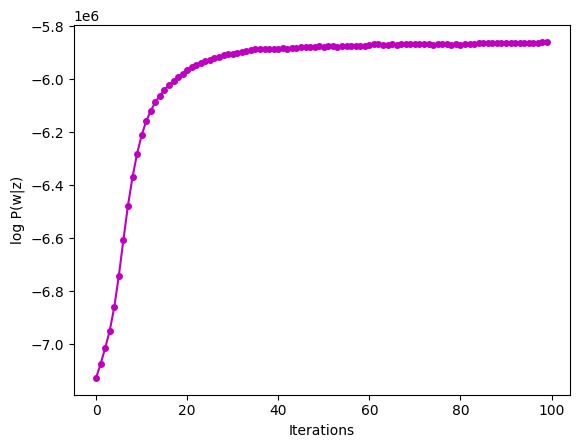

In [ ]:
# plot train loglikelihood, should increase over iterations
plt.plot(lda2.log_likelihood, "mo-", markersize = 4)
plt.xlabel('Iterations')
plt.ylabel('log P(w|z)')